# ROMS in Python - Advanced: hovmoller plots

by David Gwyther

This notebook will focus on how to plot hovmoller diagrams

In [1]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/local/m68/deg581/tmp'

In [2]:
# cartopy load the coast:

import cartopy.feature as cfeature

def loadCartopyCoast():
    Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',
                                    facecolor='none', name='coastline')
    return Coast

Coast = loadCartopyCoast()


In [3]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=16,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=48)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46417 instead
  warnings.warn(


In [4]:
print(client)

<Client: 'tcp://10.0.128.139:34223' processes=0 threads=0, memory=0 B>


## load data

In [5]:
# load multiple ROMS netcdf with xr


# filelist = glob.glob('/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/outer_his_0800*.nc')
# chunks = chunks={'ocean_time':1}
# def RemoveSomeDays(ds):
#     '''remove the last 7 timesteps from each file'''
#     return ds.isel(ocean_time = slice(0,-7))

# ds = xr.open_mfdataset(filelist,chunks, preprocess=RemoveSomeDays, data_vars='minimal', compat='override', coords='minimal', parallel=False, join='right')
# ds

# note that I turned off parallel - was finding it was freezing with dask?
# alternative: load once, chop off vars and save to a processed netcdf, then load with:

ds = xr.open_dataset('/g/data/fu5/deg581/OSSE_analysis/data/proc/output_truth_8005_8401.nc')
ds

<xarray.Dataset>
Dimensions:        (s_rho: 30, s_w: 31, tracer: 2, boundary: 4, eta_rho: 317, xi_rho: 272, xi_u: 271, eta_v: 316, ocean_time: 80)
Coordinates: (12/14)
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 ...
    lat_rho        (eta_rho, xi_rho) float64 ...
    lon_u          (eta_rho, xi_u) float64 ...
    lat_u          (eta_rho, xi_u) float64 ...
    ...             ...
    lon_psi        (eta_v, xi_u) float64 ...
    lat_psi        (eta_v, xi_u) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 2011-12-02 ... 2012-12-31
    z_w            (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    z_rho          (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    z_rho0         (eta_rho, xi_rho, s_rho) float64 ...
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/102)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    dz_w           (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    dz_u           (ocean_time, s_rho, eta_rho, xi_u) float64 ...
    dz_w_u         (ocean_time, s_w, eta_rho, xi_u) float64 ...
    dz_v           (ocean_time, s_rho, eta_v, xi_rho) float64 ...
    dz_w_v         (ocean_time, s_w, eta_v, xi_rho) float64 ...
    dA             (eta_rho, xi_rho) float64 ...
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

## let's first process our dataset and make a grid file

In [6]:
# do special processing for ROMS formatting


def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds



def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut


grid = makeROMSGridObject(ds)

In [7]:
ds

<xarray.Dataset>
Dimensions:        (s_rho: 30, s_w: 31, tracer: 2, boundary: 4, eta_rho: 317, xi_rho: 272, xi_u: 271, eta_v: 316, ocean_time: 80)
Coordinates: (12/14)
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho        (eta_rho, xi_rho) float64 -38.5 -38.51 ... -28.15 -28.16
    lon_u          (eta_rho, xi_u) float64 147.1 147.1 147.2 ... 162.1 162.2
    lat_u          (eta_rho, xi_u) float64 -38.5 -38.51 -38.52 ... -28.14 -28.15
    ...             ...
    lon_psi        (eta_v, xi_u) float64 147.1 147.2 147.2 ... 162.1 162.1 162.2
    lat_psi        (eta_v, xi_u) float64 -38.48 -38.49 -38.5 ... -28.16 -28.18
  * ocean_time     (ocean_time) datetime64[ns] 2011-12-02 ... 2012-12-31
    z_w            (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    z_rho          (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    z_rho0         (eta_rho, xi_rho, s_rho) float64 ...
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/102)
    ntimes         int32 1440
    ndtfast        int32 35
    dt             float64 300.0
    dtfast         float64 8.571
    dstart         datetime64[ns] 2011-12-02
    nHIS           int32 48
    ...             ...
    dz_w           (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    dz_u           (ocean_time, s_rho, eta_rho, xi_u) float64 ...
    dz_w_u         (ocean_time, s_w, eta_rho, xi_u) float64 ...
    dz_v           (ocean_time, s_rho, eta_v, xi_rho) float64 ...
    dz_w_v         (ocean_time, s_w, eta_v, xi_rho) float64 ...
    dA             (eta_rho, xi_rho) float64 1.498e+07 1.498e+07 ... 2.929e+07
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

In [8]:
# drop some variables to speed up loading!
ds = ds[['temp','u_eastward','v_northward','zeta','dx']]
# ds = ds.drop('z_rho')

# Let's load the u,v velocities to speed this up...
ds.load()


<xarray.Dataset>
Dimensions:      (ocean_time: 80, s_rho: 30, eta_rho: 317, xi_rho: 272)
Coordinates:
  * s_rho        (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho      (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho      (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
  * ocean_time   (ocean_time) datetime64[ns] 2011-12-02 ... 2012-12-31
    z_rho        (ocean_time, s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... -1.028
    z_rho0       (eta_rho, xi_rho, s_rho) float64 nan nan nan ... -4.483 -1.035
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 23.66
    u_eastward   (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0
    v_northward  (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0
    zeta         (ocean_time, eta_rho, xi_rho) float64 nan nan ... 0.4941 0.4941
    dx           (eta_rho, xi_rho) float64 2.996e+03 2.996e+03 ... 6e+03 6e+03
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

## calculate variables at depth for plotting

In [9]:
def horizontalSectionROMS(grid,inputVal,targetDepth):
    output = grid.transform(inputVal, 'Z', targetDepth,target_data=inputVal['z_rho0'],method='linear').squeeze()
    return output

In [10]:
ds["eke"] = 0.5*((ds.u_eastward - ds.u_eastward.mean("ocean_time"))**2 + (ds.v_northward - ds.v_northward.mean("ocean_time"))**2)

ds["eke500"] = horizontalSectionROMS(grid, ds.eke, np.array([-500]))
ds["temp500"]=horizontalSectionROMS(grid, ds.temp, np.array([-500]))

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:146: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


In [11]:
# choose a transect
etaTransect=119
vtimes = ds.ocean_time.values.astype('datetime64[ms]').astype('O')
lons = ds.lon_rho.isel(eta_rho=etaTransect)

<Figure size 432x288 with 0 Axes>

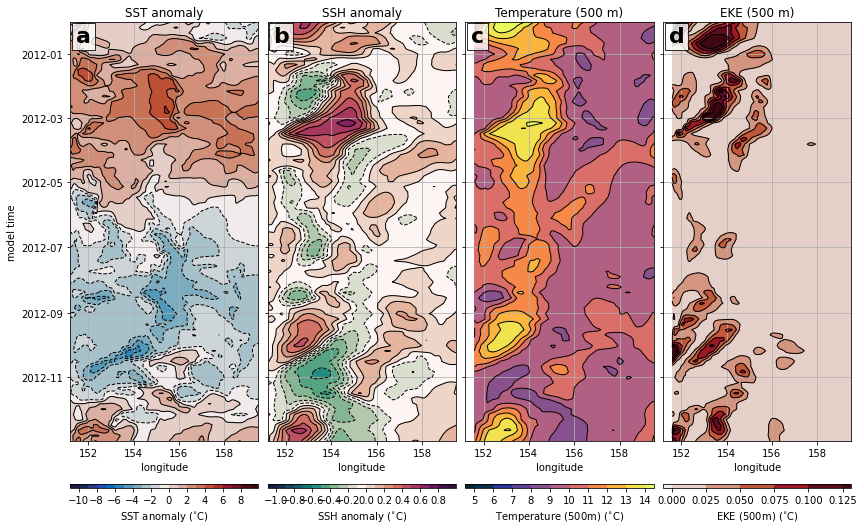

In [12]:

# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=1,ncols=4,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,10])
ax = None





ax = fig.add_subplot(gs[0,0])

ax.invert_yaxis()  # Reverse the time order to do oldest first
cf=ax.contourf(lons,vtimes,ds.temp.isel(eta_rho=etaTransect,s_rho=-1)-ds.temp.isel(eta_rho=etaTransect,s_rho=-1).mean(dim='ocean_time'),np.arange(-10,10,1),cmap=cmocean.cm.balance,extend='both')
ax.contour(lons,vtimes,ds.temp.isel(eta_rho=etaTransect,s_rho=-1)-ds.temp.isel(eta_rho=etaTransect,s_rho=-1).mean(dim='ocean_time'),np.arange(-10,10,1), colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50, extendrect=True)
cbar.set_label('SST anomaly ($^{\circ}$C)')

# ax.set_xticks([0, 90, 180, 270, 357.5])
# ax.set_xticklabels(x_tick_labels)
# ax.set_yticks(vtimes[4::8])
# ax.set_yticklabels(vtimes[4::8])
ax.set_xlim([151.2,159.5])
ax.set_ylim()
ax.set_xlabel('longitude')
ax.set_ylabel('model time')
ax.set_title('SST anomaly')
ax.text(0.03, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.grid()


ax = fig.add_subplot(gs[0,1])
ax.invert_yaxis()  # Reverse the time order to do oldest first
cf=ax.contourf(lons,vtimes,ds.zeta.isel(eta_rho=etaTransect)-ds.zeta.isel(eta_rho=etaTransect).mean(dim='ocean_time'),np.arange(-1,1,.1),cmap=cmocean.cm.curl,extend='both')
ax.contour(lons,vtimes,ds.zeta.isel(eta_rho=etaTransect)-ds.zeta.isel(eta_rho=etaTransect).mean(dim='ocean_time'),np.arange(-1,1,.1), colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50, extendrect=True)
cbar.set_label('SSH anomaly ($^{\circ}$C)')
# ax.set_xticks([0, 90, 180, 270, 357.5])
# ax.set_xticklabels(x_tick_labels)
# ax.set_yticks(vtimes[4::8])
ax.set_yticklabels([])
ax.set_xlim([151.2,159.5])
ax.set_ylim()
ax.set_xlabel('longitude')
# ax.set_ylabel('model time')
ax.set_title('SSH anomaly')
ax.text(0.03, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.grid()


ax = fig.add_subplot(gs[0,2])
ax.invert_yaxis()  # Reverse the time order to do oldest first
cf=ax.contourf(lons,vtimes,ds.temp500.isel(eta_rho=etaTransect),np.arange(5,15,1),cmap=cmocean.cm.thermal,extend='both')
ax.contour(lons,vtimes,ds.temp500.isel(eta_rho=etaTransect),np.arange(0,30,1), colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50, extendrect=True)
cbar.set_label('Temperature (500m) ($^{\circ}$C)')
# ax.set_xticks([0, 90, 180, 270, 357.5])
# ax.set_xticklabels(x_tick_labels)
# ax.set_yticks(vtimes[4::8])
# ax.set_yticklabels(vtimes[4::8])
ax.set_yticklabels([])
ax.set_xlim([151.2,159.5])
ax.set_ylim()
ax.set_xlabel('longitude')
# ax.set_ylabel('model time')
ax.set_title('Temperature (500 m)')
ax.text(0.03, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.grid()

ax = fig.add_subplot(gs[0,3])
ax.invert_yaxis()  # Reverse the time order to do oldest first
cf=ax.contourf(lons,vtimes,ds.eke500.isel(eta_rho=etaTransect),np.arange(0,.15,.025),cmap=cmocean.cm.amp,extend='both')
ax.contour(lons,vtimes,ds.eke500.isel(eta_rho=etaTransect),np.arange(0,.15,.025), colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50, extendrect=True)
cbar.set_label('EKE (500m) ($^{\circ}$C)')
# ax.set_xticks([0, 90, 180, 270, 357.5])
# ax.set_xticklabels(x_tick_labels)
# ax.set_yticks(vtimes[4::8])
# ax.set_yticklabels(vtimes[4::8])
ax.set_yticklabels([])
ax.set_xlim([151.2,159.5])
ax.set_ylim()
ax.set_xlabel('longitude')
# ax.set_ylabel('model time')
ax.set_title('EKE (500 m)')
ax.text(0.03, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.grid()
# ax.set_ylabel('model time')

In [13]:
# from this we can calculate a power spectrum in freq-wavenumber space

from scipy.fftpack import fft2 , fftfreq

fr= ds.eke500.isel(eta_rho=etaTransect,xi_rho=slice(82,272))
f = fr - ds.eke500.isel(eta_rho=etaTransect,xi_rho=slice(82,272)).mean(dim='ocean_time') #remove mean

# Calculate a 2D fourier transform of a distance-time field.

F= np.fft.fft2(f)

# use this function to calculate the relevant frequencies/wavenumbers.

dX = -fftfreq(fr.shape[1],ds.dx.isel(eta_rho=etaTransect,xi_rho=slice(82,272)))
dY = -fftfreq(fr.shape[0],432000)

# 2Dfft makes a dual sided spectrum, so extract +ve quadrant subset 
dX_ = dX[int(dX.size/2):]
dY_ = dY[int(dY.size/2):]
F_ = np.abs(F[int(dY.size/2):,int(dX.size/2):])

In [15]:
import numpy.matlib

dXX_ = np.matlib.repmat(dX_,(dY[int(dY.size/2):]).size,1)
dYY_ = np.matlib.repmat(dY_,(dX[int(dX.size/2):]).size,1).transpose()

Plot the freq-wavenumber power spectrum

(6.430041152263375e-08, 1.1574074074074074e-06)

<Figure size 432x288 with 0 Axes>

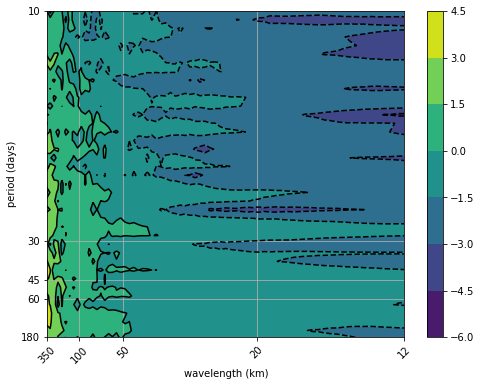

In [16]:
import matplotlib.colors as colors

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[8,6])
ax = None

ax = fig.add_subplot(gs[0,0])

cf=ax.contourf(dX_,dY_,np.log(F_))#,norm=colors.LogNorm(vmin=(np.abs(F)).min(), vmax=(np.abs(F)).max()))
co=ax.contour(dX_,dY_,np.log(F_),colors='k')#,norm=colors.LogNorm(vmin=(np.abs(F)).min(), vmax=(np.abs(F)).max()))

fig.colorbar(cf)

#
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

pxxx=np.array([12,20,50,100,350]) # x ticks are km
ax.set_xticks(1/pxxx/1000)
ax.set_xticklabels(pxxx,rotation=45) # y ticks are days
pyyy=np.array([10,30,45,60,180])
ax.set_yticks(1/pyyy/86400)
ax.set_yticklabels(pyyy)
ax.grid()
ax.set_xlabel('wavelength (km)')
ax.set_ylabel('period (days)')
ax.set_xlim([1/350/1000,1/12/1000])
ax.set_ylim([1/180/86400,1/10/86400])


We can also weight by frequency and wavenumber

(6.430041152263375e-08, 1.1574074074074074e-06)

<Figure size 432x288 with 0 Axes>

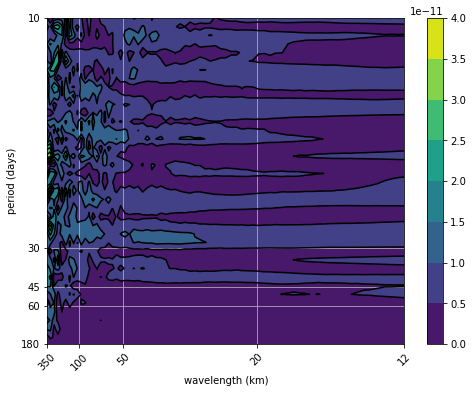

In [17]:
import matplotlib.colors as colors

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[8,6])
ax = None

ax = fig.add_subplot(gs[0,0])

cf=ax.contourf(dX_,dY_,F_*dXX_*dYY_)#,norm=colors.LogNorm(vmin=(np.abs(F)).min(), vmax=(np.abs(F)).max()))
co=ax.contour(dX_,dY_,F_*dXX_*dYY_,colors='k')#,norm=colors.LogNorm(vmin=(np.abs(F)).min(), vmax=(np.abs(F)).max()))

fig.colorbar(cf)

#
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

pxxx=np.array([12,20,50,100,350])
ax.set_xticks(1/pxxx/1000)
ax.set_xticklabels(pxxx,rotation=45)
pyyy=np.array([10,30,45,60,180])
ax.set_yticks(1/pyyy/86400)
ax.set_yticklabels(pyyy)
ax.grid()
ax.set_xlabel('wavelength (km)')
ax.set_ylabel('period (days)')
ax.set_xlim([1/350/1000,1/12/1000])
ax.set_ylim([1/180/86400,1/10/86400])
